In [15]:
from astropy.stats import sigma_clipped_stats
from photutils import datasets

import numpy as np
import pandas as pd
import os

from astropy.io import fits
import astropy
from ccdproc import ImageFileCollection

## 1 Getting Image Collection

In [17]:
path = 'data/FinalData/'


keywords = ['object', 'filter', 'crval1', 'crval2', 'date-obs', 'exporg', 
            'exposure', 'egain', 'gain', 'airmass', 'binning', 'ncombine']

# 'ra-d', 'dec-d',

ic = ImageFileCollection(path, glob_include='2019*.fits', keywords=keywords, ext=0)


## 2 Selecting data and a few keywords lists



In [18]:
# Converting ImageCollection to Pandas Data Frame
df = ic.summary.to_pandas()

df

file  object filter      crval1  \
0   2019-07-17_H_G93-48_c1-4_58681_21902.mos.fits  G93-48      H  328.058945   
1   2019-07-17_J_G93-48_c1-4_58681_21612.mos.fits  G93-48      J  328.052441   
2  2019-07-17_Ks_G93-48_c1-4_58681_22325.mos.fits  G93-48     Ks  328.059067   

     crval2    date-obs  exporg  exposure  egain  gain  airmass  binning  \
0  2.437661  2019-07-17   2.911    14.555   2.65   1.0    1.298      NaN   
1  2.411114  2019-07-17   2.911    14.555   2.65   1.0    1.309      NaN   
2  2.437267  2019-07-17   2.911    14.555   2.65   1.0    1.282      NaN   

   ncombine  
0       5.0  
1       5.0  
2       5.0


## 2. Running DAOStarFinder

In [19]:
### Input parameters for DAOStarFinder according to the fits files:

  # ccd1032c1.fits   fwhm=21.  threshold=9*std


In [20]:
# Getting fits data and metadata
filename = '2019-07-17_H_G93-48_c1-4_58681_21902.mos.fits'

hdu = fits.open(path+filename)
header = hdu[0].header
data = hdu[0].data 

# Getting sigma clipped statistics
mean, median, std = sigma_clipped_stats(data, sigma=3.0, cenfunc='median', stdfunc='std')  

# Getting ra, dec coordinates
ra_deg = header['crval1']
dec_deg = header['crval2']


from photutils import DAOStarFinder
daofind = DAOStarFinder(fwhm=5, threshold=15.0*std)  
sources = daofind(data - median)  
for col in sources.colnames:
    sources[col].info.format = '%.8g'  # for consistent table output
    
df = sources.to_pandas()

In [21]:
df.sharpness.max()

0.6179299283805085

In [264]:
df

id    xcentroid    ycentroid  sharpness  roundness1  roundness2  npix  \
0      1  3635.622000    94.567539   0.498293   -0.023426    0.043655    49   
1      2  3494.473918    97.464452   0.500567   -0.250090   -0.112074    49   
2      3  3385.660935   107.659669   0.237183   -0.082650   -0.441179    49   
3      4  1690.884142   111.994931   0.478828   -0.106162   -0.195139    49   
4      5  2622.502654   115.071252   0.479180   -0.138797   -0.145303    49   
..   ...          ...          ...        ...         ...         ...   ...   
252  253  2350.174934  4185.639644   0.525434   -0.512288   -0.177165    49   
253  254  3627.127322  4271.517094   0.456369    0.054313   -0.036179    49   
254  255  3815.173026  4278.361089   0.510193   -0.416032   -0.128350    49   
255  256   249.889729  4279.718339   0.491693    0.162347   -0.071837    49   
256  257   243.807253  4280.266945   0.430073    0.193992   -0.729216    49   

     sky         peak       flux       mag  
0    0.0   249.462860   1.615012 -0.520439  
1    0.0  6127.644531  40.795156 -4.026521  
2    0.0   143.018875   1.211116 -0.207965  
3    0.0   573.193115   3.912406 -1.481110  
4    0.0   793.359619   5.494763 -1.849872  
..   ...          ...        ...       ...  
252  0.0   204.382629   1.341234 -0.318762  
253  0.0  1116.458618   8.192944 -2.283600  
254  0.0  4981.672363  36.113810 -3.894183  
255  0.0  2811.496582  20.217428 -3.264315  
256  0.0   800.061157   5.015177 -1.750716  

[257 rows x 11 columns]

## 2.1 Plotting

<IPython.core.display.Javascript object>


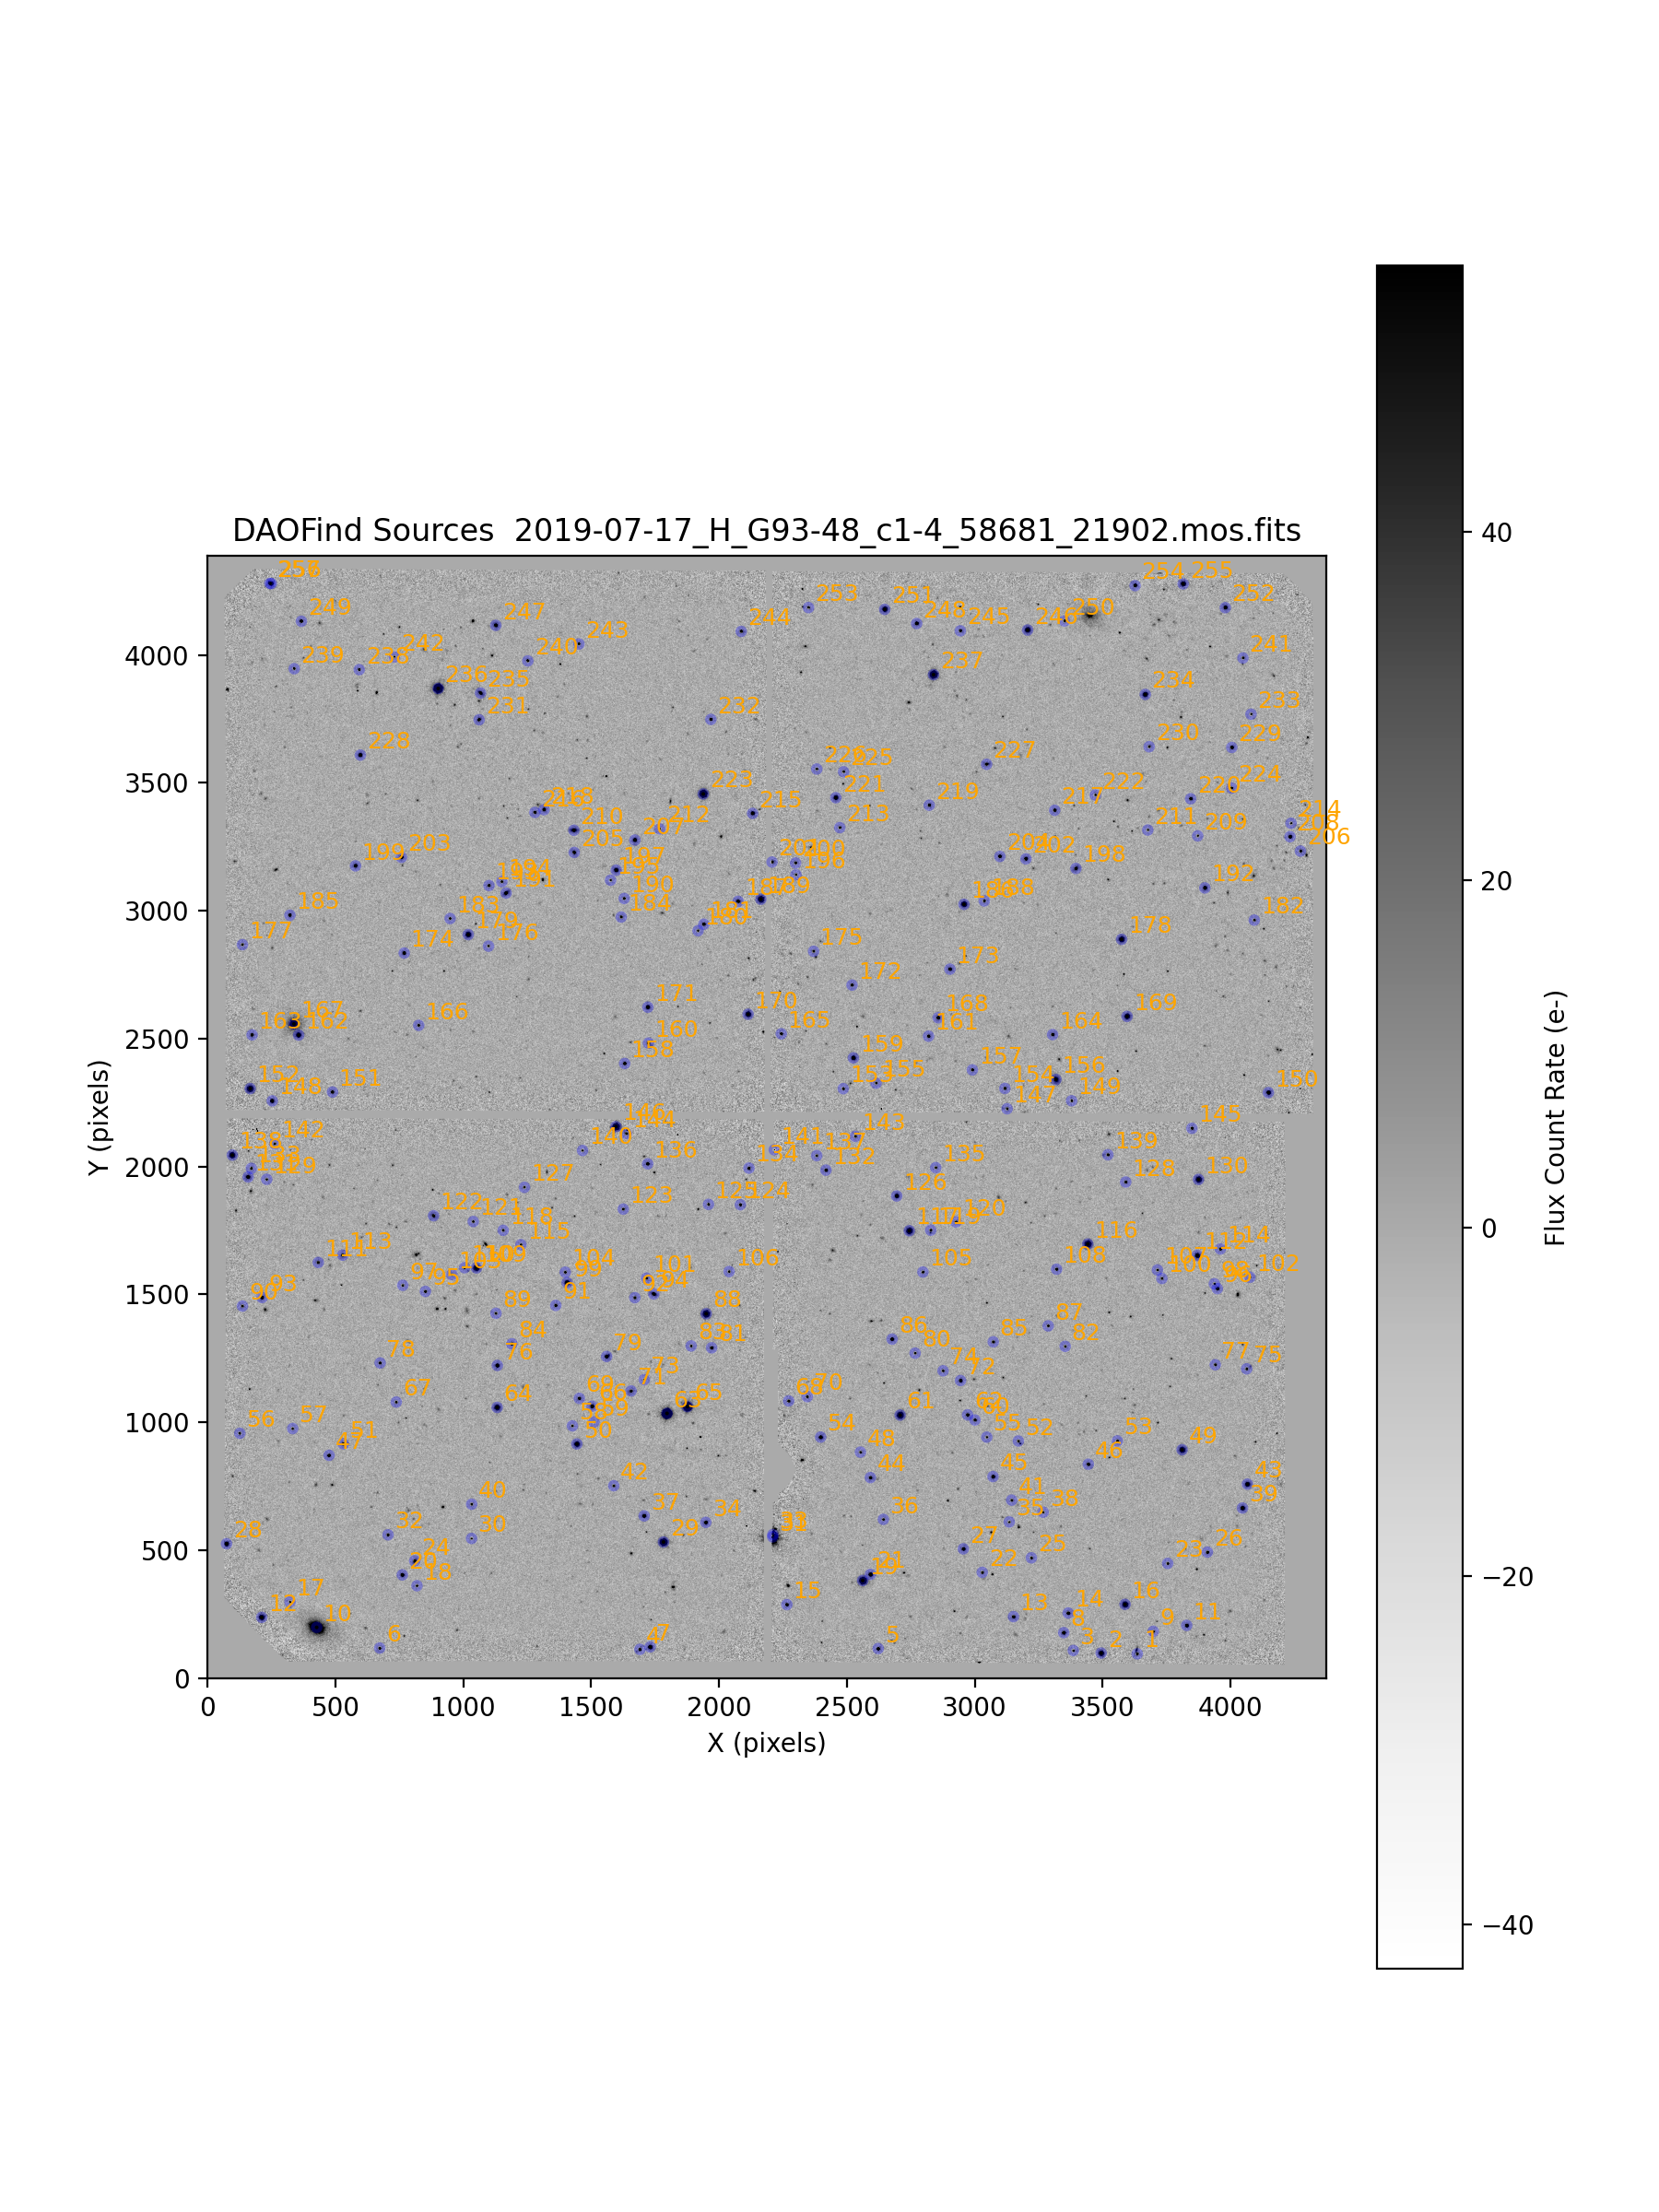

Text(0.5, 1.0, 'DAOFind Sources  2019-07-17_H_G93-48_c1-4_58681_21902.mos.fits')

In [23]:
%matplotlib notebook
import matplotlib.pyplot as plt

from astropy.visualization import (MinMaxInterval, PercentileInterval, ZScaleInterval)
from astropy.visualization import (SqrtStretch, ImageNormalize, LinearStretch, LogStretch)
from photutils import CircularAperture

# Set up the figure with subplots
fig, ax1 = plt.subplots(1, 1, figsize=(9, 12))

### Plot the data

# Getting normalization
norm_image = ImageNormalize(data, interval=PercentileInterval(99.5), stretch=LinearStretch())

plt.imshow(data, cmap='Greys', origin='lower', norm=norm_image, interpolation='nearest')

fitsplot = ax1.imshow(data, origin='lower', norm=norm_image, cmap='Greys')

#### Plotting circle around sources

# Method 1 (photoutils built-in funcitons)
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=15.)
apertures.plot(color='blue', lw=1.5, alpha=0.3)

# Method 2 (matplotlib function)
#ax1.scatter(sources['xcentroid'], sources['ycentroid'], s=30, marker='o',  lw=1, alpha=0.5, 
#            facecolor='None', edgecolor='b')

xc = list(sources['xcentroid'])
yc = list(sources['ycentroid'])

for i, txt in enumerate(list(sources['id'])):
    ax1.annotate(txt, (xc[i]+25.0, yc[i]+25.0), fontsize=9, color='orange')
    
# This is just to check if the annotate showing the correct labels
#apertures[0].plot(color='orange')

# Define the colorbar and fix the labels
cbar = plt.colorbar(fitsplot, fraction=0.09, pad=0.04)

# Define labels
cbar.set_label(r'Flux Count Rate (e-)')

ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
ax1.set_title('DAOFind Sources  ' + filename)



## 3. Getting Aperture Photometry of the identified sources

In [24]:
from photutils import aperture_photometry
from photutils import CircularAperture, CircularAnnulus


positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=30.)

annulus_aperture = CircularAnnulus(positions, r_in=35, r_out=45)
annulus_masks = annulus_aperture.to_mask(method='center')

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)

phot = aperture_photometry(data, apertures)
phot['annulus_median'] = bkg_median
phot['aper_bkg'] = bkg_median * apertures.area
phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']

for col in phot.colnames:
    phot[col].info.format = '%.8g'  # for consistent table output
print(phot)

phot_df = phot.to_pandas()


 id  xcenter   ycenter  aperture_sum annulus_median  aper_bkg  aper_sum_bkgsub
       pix       pix                                                          
--- --------- --------- ------------ -------------- ---------- ---------------
  1  3635.622 94.567539     17655.43              0          0        17655.43
  2 3494.4739 97.464452    216739.78              0          0       216739.78
  3 3385.6609 107.65967    6660.5378      1.2965713  3665.9689        2994.569
  4 1690.8841 111.99493    22849.605     0.98373425  2781.4431       20068.162
  5 2622.5027 115.07125    29017.369    -0.16203999 -458.15727       29475.526
  6 673.42925 117.24836    11768.709     -0.3618632 -1023.1441       12791.854
  7 1730.8664 121.78537    100647.26       1.768298  4999.7449       95647.517
  8 3348.0428 177.40694    48256.108     0.05567333  157.41263       48098.696
  9 3698.1062 182.52415    8808.4249    -0.39647429 -1121.0046       9929.4295
 10 426.97082 197.99417    327078.67      16.181708 

In [271]:
phot_df[phot_df.id == 1]

id   xcenter    ycenter  aperture_sum  annulus_median  aper_bkg  \
0   1  3635.622  94.567539   17655.42991             0.0       0.0   

   aper_sum_bkgsub  
0      17655.42991

In [272]:
df[df.id == 1]

id  xcentroid  ycentroid  sharpness  roundness1  roundness2  npix  sky  \
0   1   3635.622  94.567539   0.498293   -0.023426    0.043655    49  0.0   

        peak      flux       mag  
0  249.46286  1.615012 -0.520439

## 3.1 Plotting annulus apertures to check photometry

<IPython.core.display.Javascript object>


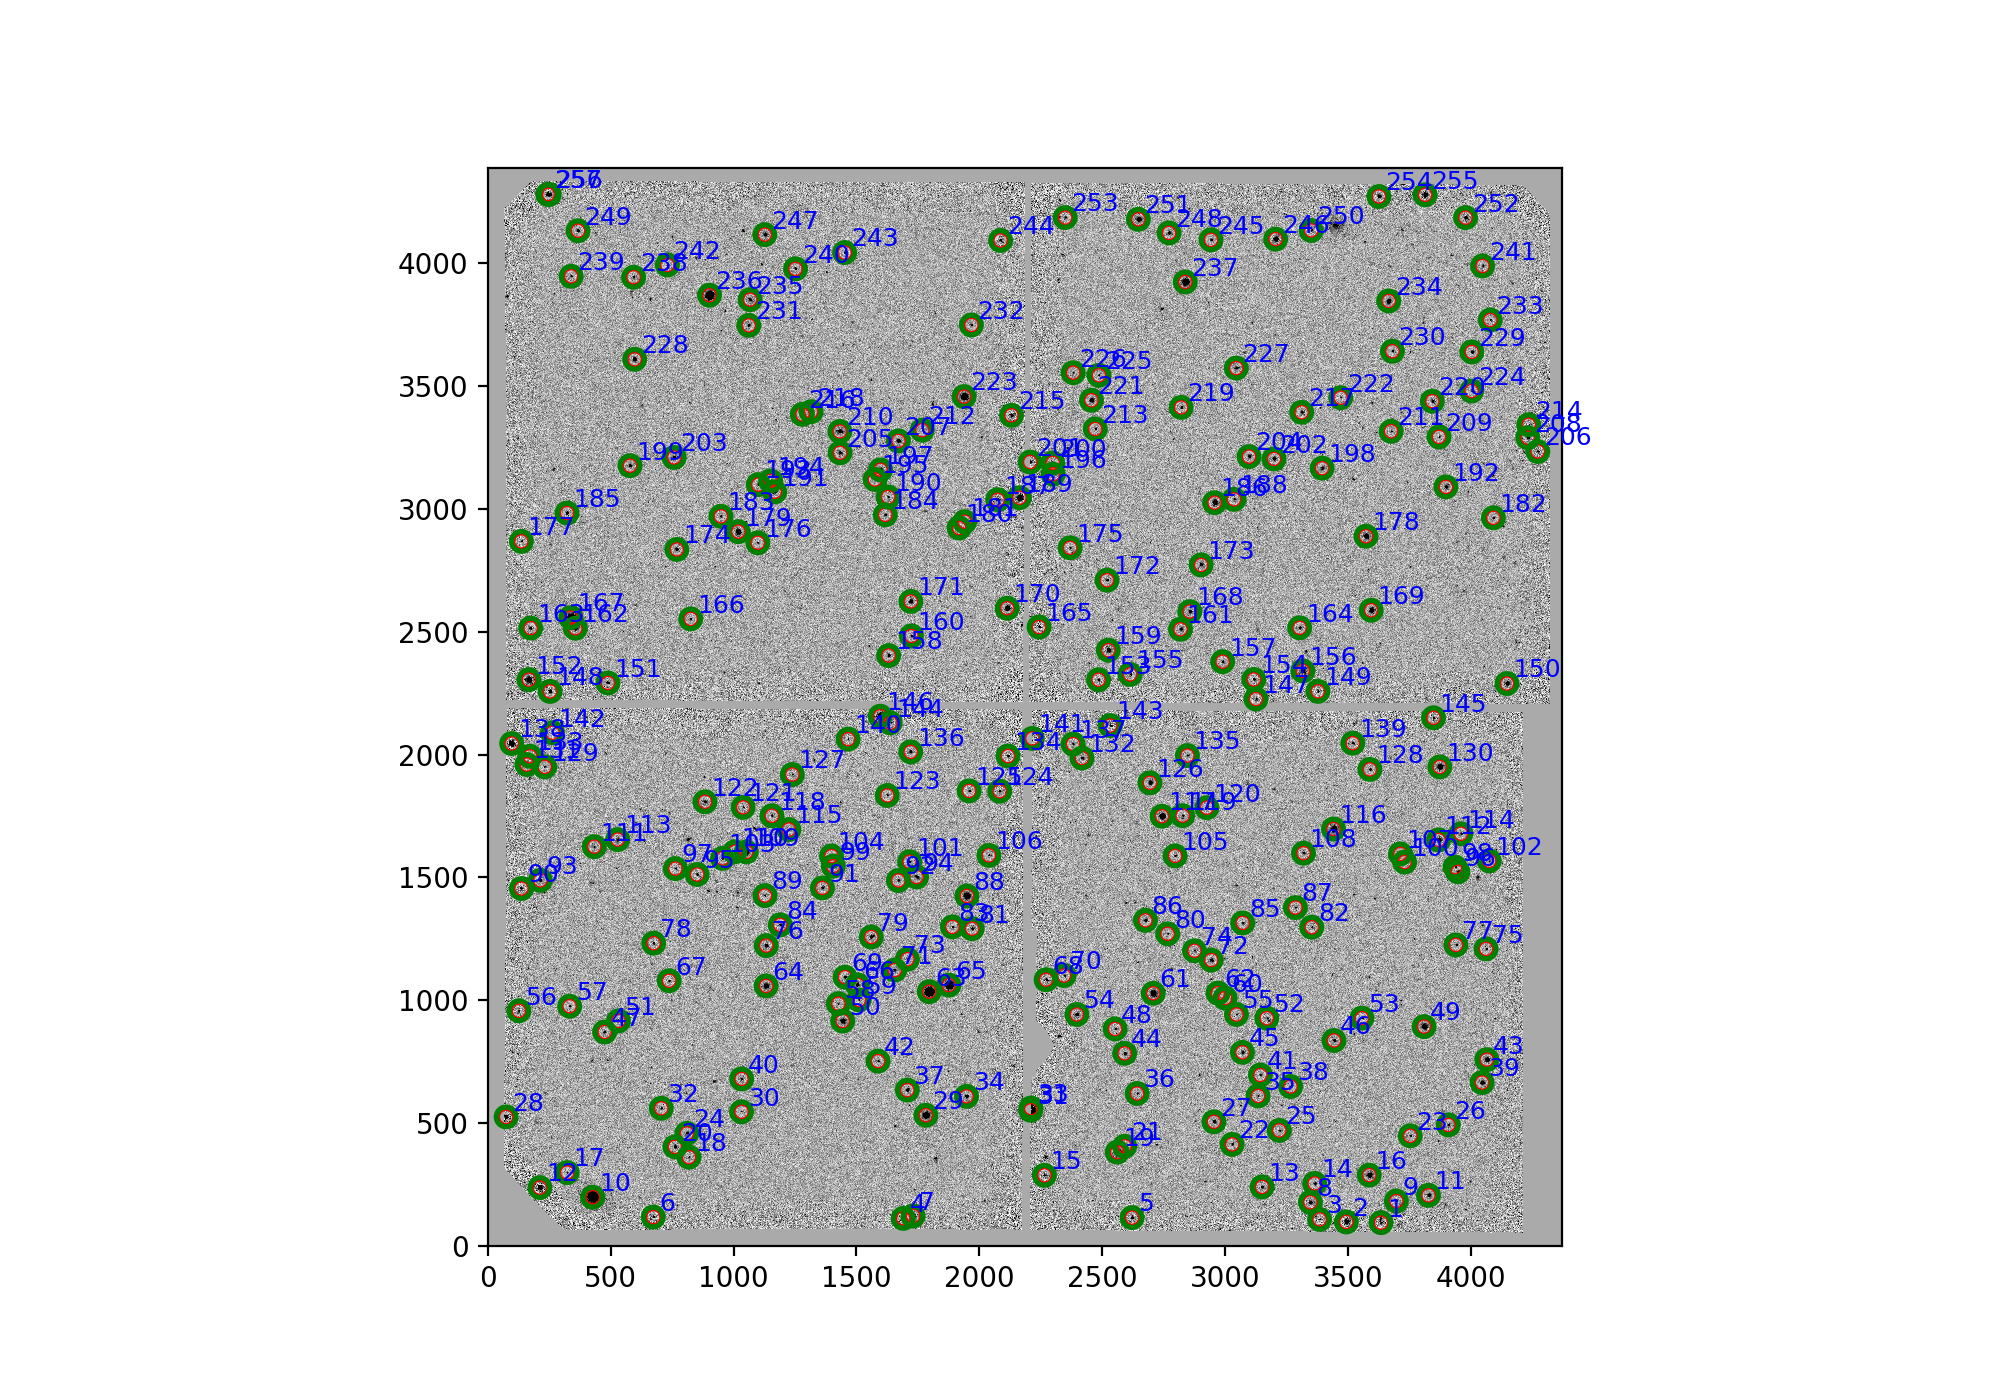

In [25]:
%matplotlib notebook
from astropy.visualization import simple_norm

norm = simple_norm(data, 'linear', percent=99.5)
plt.figure(figsize=(10,7))
plt.imshow(data, norm=norm, origin='lower', cmap='Greys', interpolation='nearest')
apertures.plot(color='red', lw=1)
annulus_aperture.plot(color='green', lw=1)

xc = list(phot_df['xcenter'])
yc = list(phot_df['ycenter'])

for i, txt in enumerate(list(phot_df['id'])):
    plt.annotate(txt, (xc[i]+25.0, yc[i]+25.0), fontsize=9, color='blue')




## 4 Estimating Zero Points 

In [26]:
source_id = 64

sources.to_pandas().loc[sources.to_pandas()['id'] ==  source_id]

id    xcentroid    ycentroid  sharpness  roundness1  roundness2  npix  \
63  64  1132.690614  1058.196644   0.492698   -0.064496   -0.013607    49   

    sky         peak       flux       mag  
63  0.0  9279.169922  68.718361 -4.592682

In [186]:
#table.loc[table['Star_name'] ==  b'97_249     ']

In [11]:
import numpy as np
import math

#zpt = photo_df.z_Sloan - (-2.5*np.log10(photo_df.aper_sum_bkgsub))  + np.ones(len(photo_df.id)) * ( (airmass-1)*z_ext_coef - 2.5*math.log10(exptime))

# Ext coef. (for La Silla, from https://www.researchgate.net/publication/49943315_Near-infrared_jet_emission_in_the_microquasar_XTE_J1550-564/figures)
#ext_coef = {'J': 0.08, 'H': 0.03, 'Ks': 0.05}
ext_coef = {'J': 0.1, 'H': 0.05, 'Ks': 0.05}


# 2MASS mags. for G93-48
#J = 13.203±0.024
#H = 13.286±0.037
#K = 13.397±0.037
mag_ref = {'J': 13.203, 'H': 13.286, 'Ks': 13.397}

_airmass = np.float(header['airmass'])
_exptime = np.float(header['exptime'])
_filter = str(header['filter'])
_dateobs = str(header['date-obs'])
_object = str(header['object']).split()[0]
_gain = np.float(header['gain'])

aper_sum = np.float(phot_df.loc[phot_df['id'] == source_id]['aper_sum_bkgsub'])

zpt = mag_ref[_filter] + (2.5*np.log10(_gain*aper_sum/_exptime)) + (_airmass-1)*ext_coef[_filter]

print('{} {} {} {:4.2f} {:4.2f} {}'.format(_dateobs, _object, _filter, zpt, _exptime, _gain))

2019-07-17 G93-48 H 26.91 1.00 1.0


In [167]:
%%writefile ZPT_FSTAR_20190717.txt
2019-07-17 G93-48  J 26.61
2019-07-17 G93-48  H 26.91
2019-07-17 G93-48 Ks 26.00

J = 27.109±0.007    n=20 2mass stars
H = 26.832±0.008    n=20 2mass stars
K = 25.983±0.008    n=22 2mass stars

Overwriting ZPT_FSTAR_20190717.txt


## 5 Editing a fits table

In [29]:
from astropy.io import fits

fits_table_filename = '/Users/dsanmartim/Dropbox/Engineering/Calibrations_and_Tools/Data_Reduction/IMACS_photometry/SDSS_full_ugriz_bvri.fits'

hdul = fits.open(fits_table_filename)  # open a FITS file
data = hdul[1].data  # assume the first extension is a table

# show the first two rows
first_two_rows = data[:2]
first_two_rows  

hdul.info()

Filename: /Users/dsanmartim/Dropbox/Engineering/Calibrations_and_Tools/Data_Reduction/IMACS_photometry/SDSS_full_ugriz_bvri.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (7271,)   uint8   
  1  Joined        1 BinTableHDU    158   100R x 38C   ['11A', '8A', '9A', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', '11A', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'I', '12A', '12A', 'D', 'D', 'D', 'E', 'E', 'E', 'E', 'D', 'D']   


In [30]:
from astropy.table import Table

table = Table.read(fits_table_filename, hdu=1)

table = table.to_pandas()

table

Star_name      RA_2000      DEC_2000       u  u_err       g  g_err  \
0   b'92_342     '  b'00:55:09'  b'+00:43:13'  12.853  0.004  11.784  0.001   
1   b'92_263     '  b'00:55:39'  b'+00:36:19'  14.495  0.008  12.268  0.001   
2   b'92_502     '  b'00:56:08'  b'+01:04:25'  13.032  0.004  12.001  0.003   
3   b'92_282     '  b'00:56:46'  b'+00:38:29'  14.072  0.017  13.072  0.002   
4   b'92_288     '  b'00:57:16'  b'+00:36:48'  13.778  0.012  12.011  0.005   
..             ...          ...           ...     ...    ...     ...    ...   
95  b'114_750    '  b'22:41:44'  b'+01:12:36'  12.357  0.005  11.809  0.002   
96  b'GD246      '  b'23:12:21'  b'+10:47:04'  12.351  0.004  12.842  0.002   
97  b'PG2336+004B'  b'23:38:38'  b'+00:42:47'  13.749  0.006  12.648  0.003   
98  b'115_420    '  b'23:42:36'  b'+01:05:57'  12.444  0.004  11.353  0.002   
99  b'115_516    '  b'23:44:15'  b'+01:14:12'  13.079  0.009  10.914  0.003   

         r  r_err       i  ...          DEJ2000   pmRA  pmDE Separation  \
0   11.527  0.001  11.478  ...  b'+00 43 12.88'   -1.9  -1.4  13.574458   
1   11.467  0.001  11.160  ...  b'+00 36 19.50'    6.3  -2.3   5.781340   
2   11.712  0.002  11.634  ...  b'+01 04 25.04'    5.9   3.2   1.890092   
3   12.936  0.004  12.915  ...  b'+00 38 29.50'   22.1  -7.3  12.264428   
4   11.350  0.002  11.117  ...  b'+00 36 48.67'    3.3   4.4  15.089018   
..     ...    ...     ...  ...              ...    ...   ...        ...   
95  12.021  0.002  12.251  ...  b'+01 12 36.36'  -12.5 -19.7  10.548793   
96  13.346  0.001  13.724  ...  b'+10 47 04.30'  142.0 -10.0   9.287940   
97  12.312  0.001  12.212  ...  b'+00 42 46.40'   10.4  -1.1   4.346281   
98  11.063  0.002  10.983  ...  b'+01 05 58.82'   -5.7  -6.7   7.439722   
99  10.107  0.002   9.790  ...  b'+01 14 12.56'   30.2 -21.4   5.651503   

         Bmag       Rmag       Imag       Umag    RA_J2000  DEC_J2000  
0   12.050000  11.349999  11.078000  12.013000   13.787500   0.720278  
1   12.827999  11.219999  10.698999  13.671999   13.912500   0.605278  
2   12.298000  11.528000  11.236000  12.203000   14.033333   1.073611  
3   13.287000  12.768000  12.547000  13.249000   14.191667   0.641389  
4   12.488999  11.139999  10.698999  12.960999   14.316667   0.613333  
..        ...        ...        ...        ...         ...        ...  
95  11.879001  11.889000  11.906000  11.512001  340.433333   1.210000  
96  12.772000  13.238000  13.418000  11.578000  348.087500  10.784444  
97  12.946000  12.116000  11.802000  12.898000  354.658333   0.713056  
98  11.627000  10.872000  10.579000  11.608000  355.650000   1.099167  
99  11.459000   9.867000   9.332000  12.219000  356.062500   1.236667  

[100 rows x 38 columns]

In [31]:
table.loc[table['Star_name'] ==  b'97_249     ']

Star_name      RA_2000      DEC_2000       u  u_err       g  g_err  \
25  b'97_249     '  b'05:57:07'  b'+00:01:10'  13.334  0.005  12.018  0.002   

         r  r_err       i  ...          DEJ2000  pmRA  pmDE Separation  \
25  11.567  0.001  11.426  ...  b'+00 01 11.50'  15.2   1.2   8.532877   

      Bmag       Rmag       Imag    Umag   RA_J2000  DEC_J2000  
25  12.382  11.365999  11.009999  12.483  89.279167   0.019444  

[1 rows x 38 columns]

In [27]:
from astroquery.irsa import Irsa
import astropy.units as u

In [28]:
#Irsa.print_catalogs()

# fp_psc                          2MASS All-Sky Point Source Catalog (PSC)

# Doc >> https://astroquery.readthedocs.io/en/latest/irsa/irsa.html

In [29]:
header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 4374 / Axis length                                    
NAXIS2  =                 4388 / Axis length                                    
EXTEND  =                    T / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2020-08-01T00:37:50' / Date FITS file was generated                  
IRAF-TLM= '2020-08-01T00:37:53' / Time of last modification                     
OBJECT  = 'G93-48  '           / Name of the object observed                    
EQUINOX =        2000.00000000 / Mean equinox                                   
MJD-OBS =   5.868100000000E+04 / Modified Julian date at start                  
RADESYS = 'ICRS    '        

In [52]:
# Box search
#table = Irsa.query_region("G93-48", catalog="fp_psc", spatial="Box", width=12 * u.arcmin)

# Cone search
table = Irsa.query_region("G93-48", catalog="fp_psc", spatial="Cone", radius=7.0 * u.arcmin)


In [54]:
_2mass = table.to_pandas()

/Users/dsanmartim/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3343: TableReplaceWarning: converted column 'phi_opt' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/dsanmartim/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3343: TableReplaceWarning: converted column 'ext_key' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [55]:
_2mass

ra       dec             clon             clat  err_maj  err_min  \
0    328.105752  2.388679  b'21h52m25.38s'  b'02d23m19.24s'     0.07     0.07   
1    328.105905  2.394382  b'21h52m25.42s'  b'02d23m39.78s'     0.08     0.08   
2    328.103412  2.398226  b'21h52m24.82s'  b'02d23m53.61s'     0.35     0.32   
3    328.091501  2.388842  b'21h52m21.96s'  b'02d23m19.83s'     0.16     0.16   
4    328.091627  2.380795  b'21h52m21.99s'  b'02d22m50.86s'     0.07     0.07   
..          ...       ...              ...              ...      ...      ...   
149  327.996655  2.352903  b'21h51m59.20s'  b'02d21m10.45s'     0.09     0.08   
150  328.009307  2.451932  b'21h52m02.23s'  b'02d27m06.96s'     0.26     0.25   
151  327.996479  2.426497  b'21h51m59.15s'  b'02d25m35.39s'     0.37     0.34   
152  328.054138  2.285143  b'21h52m12.99s'  b'02d17m06.51s'     0.08     0.08   
153  328.192920  2.311310  b'21h52m46.30s'  b'02d18m40.72s'     0.15     0.14   

     err_ang          designation     j_m  j_cmsig  ...  phi_opt  b_m_opt  \
0         90  b'21522538+0223192'  13.203    0.020  ...    173.0    12.47   
1         90  b'21522541+0223397'  15.394    0.058  ...      NaN      NaN   
2        146  b'21522481+0223536'  16.678    0.173  ...     80.0    17.60   
3         92  b'21522196+0223198'  16.573    0.171  ...    307.0    18.20   
4         90  b'21522199+0222508'  14.222    0.031  ...     92.0    19.90   
..       ...                  ...     ...      ...  ...      ...      ...   
149       88  b'21515919+0221104'  13.399    0.017  ...     81.0    14.90   
150       22  b'21520223+0227069'  16.490    0.119  ...      NaN      NaN   
151       76  b'21515915+0225353'  16.816    0.152  ...    176.0    19.80   
152       45  b'21521299+0217065'  15.288    0.040  ...      NaN      NaN   
153       99  b'21524630+0218407'  16.305    0.114  ...     40.0    18.70   

     vr_m_opt  nopt_mchs  ext_key        dist       angle    j_h    h_k    j_k  
0       13.28          1      NaN    0.327679  178.742048 -0.083 -0.111 -0.194  
1         NaN          0      NaN   20.210891    1.580692  0.727  0.087  0.814  
2       17.50          1      NaN   35.064933  346.123821  0.634  0.133  0.767  
3       17.40          1      NaN   51.252479  270.290061  1.113    NaN    NaN  
4       17.60          1      NaN   58.350482  240.526410  0.525  0.372  0.897  
..        ...        ...      ...         ...         ...    ...    ...    ...  
149     14.30          1      NaN  413.103626  251.788463  0.273  0.070  0.343  
150       NaN          0      NaN  414.767834  303.246875  0.484  0.429  0.913  
151     18.50          1      NaN  415.833604  289.065695  0.355  1.023  1.378  
152       NaN          0      NaN  416.697844  206.457891  0.676  0.142  0.818  
153     17.40          1      NaN  419.610591  131.646706  0.936    NaN    NaN  

[154 rows x 44 columns]

In [201]:
from astropy import wcs


# Good link about contraining parameters
#https://docs.astropy.org/en/stable/modeling/example-fitting-constraints.html

In [86]:
def load_wcs_from_file(filename):
    # Load the FITS hdulist using astropy.io.fits
    hdulist = fits.open(filename)

    # Parse the WCS keywords in the primary HDU
    w = wcs.WCS(hdulist[0].header)

    # Print out the "name" of the WCS, as defined in the FITS header
    print(w.wcs.name)

    # Print out all of the settings that were parsed from the header
    w.wcs.print_contents()


In [89]:
hdulist = fits.open(path+filename)

In [99]:
w = wcs.WCS(hdulist[0].header)

In [100]:
xy = []

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 328.0589452494  2.437660674721  
CRPIX : 2188.5  2195.5  
CD1_1 CD1_2  : -4.444444444444e-05  0.0  
CD2_1 CD2_2  : 0.0  4.444444444444e-05  
NAXIS : 4374  4388

In [134]:
    # Three pixel coordinates of interest.
    # Note we've silently assumed an NAXIS=2 image here.
    # The pixel coordinates are pairs of [X, Y].
    # The "origin" argument indicates whether the input coordinates
    # are 0-based (as in Numpy arrays) or
    # 1-based (as in the FITS convention, for example coordinates
    # coming from DS9).
#pixcrd = np.array([[0, 0], [2188.5, 2195.5], [1876.81, 1061.48]], dtype=np.float64)
pixcrd = np.transpose([df.xcentroid, df.ycentroid])

# Convert pixel coordinates to world coordinates
# The second argument is "origin" -- in this case we're declaring we
# have 0-based (Numpy-like) coordinates.
world = w.wcs_pix2world(pixcrd, 0)
#print(world)

# Convert the same coordinates back to pixel coordinates.
pixcrd2 = w.wcs_world2pix(world, 0)
#print(pixcrd2)

# These should be the same as the original pixel coordinates, modulo
# some floating-point error.
assert np.max(np.abs(pixcrd - pixcrd2)) < 1e-6

# The example below illustrates the use of "origin" to convert between
# 0- and 1- based coordinates when executing the forward and backward
# WCS transform.
x = 0
y = 0
origin = 0
assert (w.wcs_pix2world(x, y, origin) ==
        w.wcs_pix2world(x + 1, y + 1, origin + 1))


In [150]:
assert np.max(np.abs(pixcrd - pixcrd2)) < 1e-6

In [152]:
w.to_header()

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =               2188.5 / Pixel coordinate of reference point            
CRPIX2  =               2195.5 / Pixel coordinate of reference point            
PC1_1   =  -4.444444444444E-05 / Coordinate transformation matrix element       
PC2_2   =   4.444444444444E-05 / Coordinate transformation matrix element       
CDELT1  =                  1.0 / [deg] Coordinate increment at reference point  
CDELT2  =                  1.0 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---TAN'           / Right ascension, gnomonic projection           
CTYPE2  = 'DEC--TAN'           / Declination, gnomonic projection               
CRVAL1  =       328.0589452494 / [deg] Coordinate value at reference point      
CRVAL2  =       2.4376606747

In [125]:
np.transpose([df.xcentroid, df.ycentroid])

array([[3635.62199992,   94.56753947],
       [3494.47391758,   97.46445222],
       [3385.66093535,  107.65966942],
       [1690.88414246,  111.99493139],
       [2622.50265416,  115.0712522 ],
       [ 673.42924676,  117.24836217],
       [1730.86639127,  121.78537346],
       [3348.04282386,  177.4069375 ],
       [3698.10615918,  182.52414851],
       [ 426.97082347,  197.99417445],
       [3828.844547  ,  205.83070644],
       [ 211.95440496,  237.26399243],
       [3151.5643975 ,  240.0466463 ],
       [3365.63624484,  254.10693102],
       [2265.56122108,  287.2759233 ],
       [3587.91506272,  288.04702787],
       [ 322.89747831,  298.21314657],
       [ 819.09786958,  360.9970314 ],
       [2562.0413472 ,  381.3765163 ],
       [ 761.86236662,  403.39063236],
       [2592.29989618,  405.26917118],
       [3029.51308476,  413.11925593],
       [3754.6719515 ,  448.11544889],
       [ 810.24347199,  458.08398069],
       [3221.59636746,  469.9308274 ],
       [3909.82932047,  4

In [123]:
[df.xcentroid, df.ycentroid]

[0      3635.622000
 1      3494.473918
 2      3385.660935
 3      1690.884142
 4      2622.502654
           ...     
 252    2350.174934
 253    3627.127322
 254    3815.173026
 255     249.889729
 256     243.807253
 Name: xcentroid, Length: 257, dtype: float64,
 0        94.567539
 1        97.464452
 2       107.659669
 3       111.994931
 4       115.071252
           ...     
 252    4185.639644
 253    4271.517094
 254    4278.361089
 255    4279.718339
 256    4280.266945
 Name: ycentroid, Length: 257, dtype: float64]

<IPython.core.display.Javascript object>


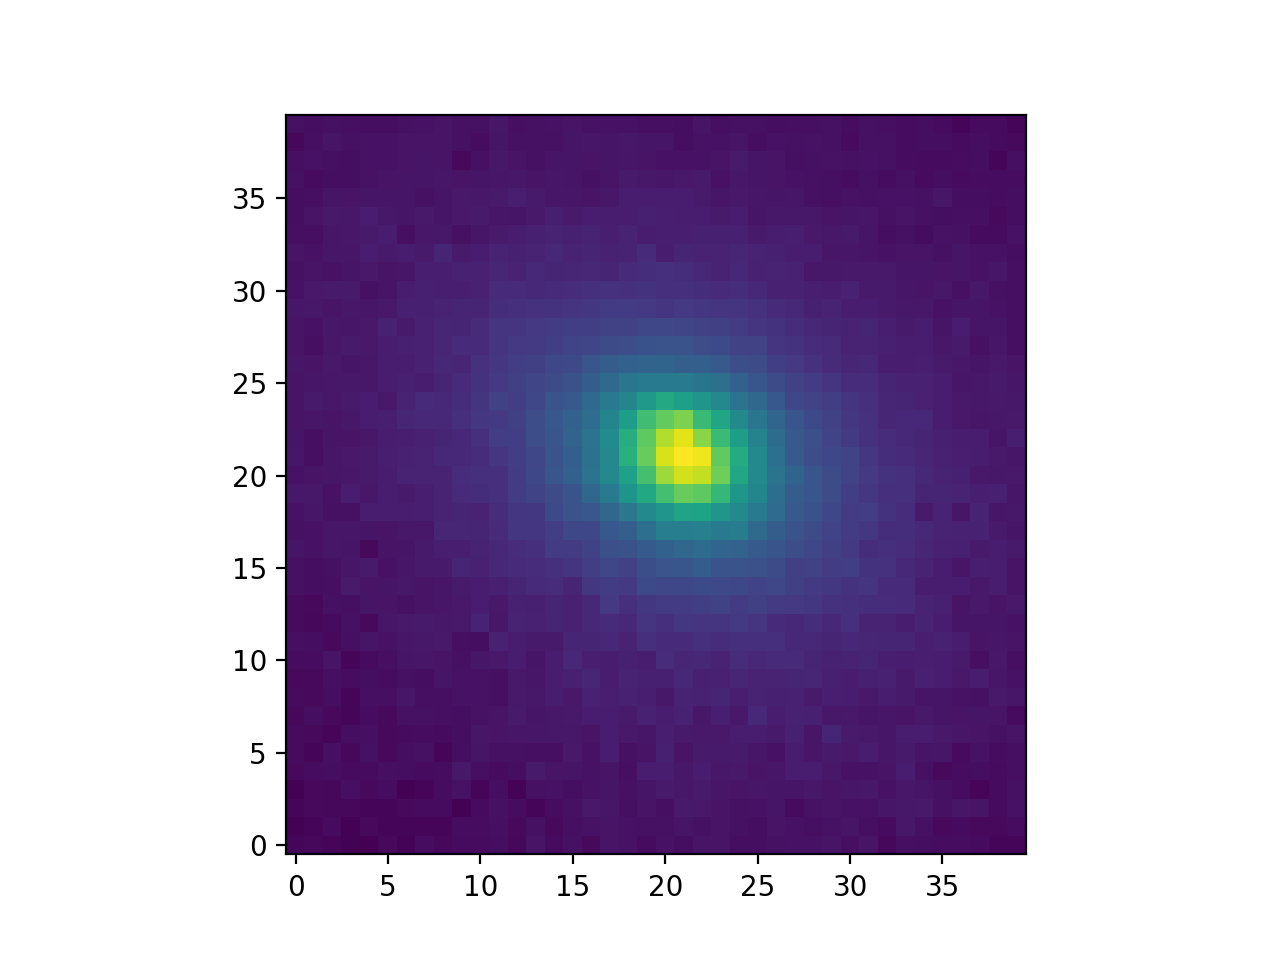

In [281]:
%matplotlib notebook
hdu = fits.open(path+filename)
header = hdu[0].header
data = hdu[0].data 

# STAR ID

sid = 10
x, y = df.xcentroid[df.id == sid], df.ycentroid[df.id == sid]
x0, y0 = int(x.values),int(y.values)

x1, x2 = x0-20, x0+20
y1, y2 = y0-20, y0+20

sdata = data[y1:y2, x1:x2]

#eps = np.min(model_data[model_data > 0]) / 10.0
# use logarithmic scale for sharp Gaussians
plt.imshow(sdata, origin='lower', label='Gaussian') 
plt.show()


<IPython.core.display.Javascript object>


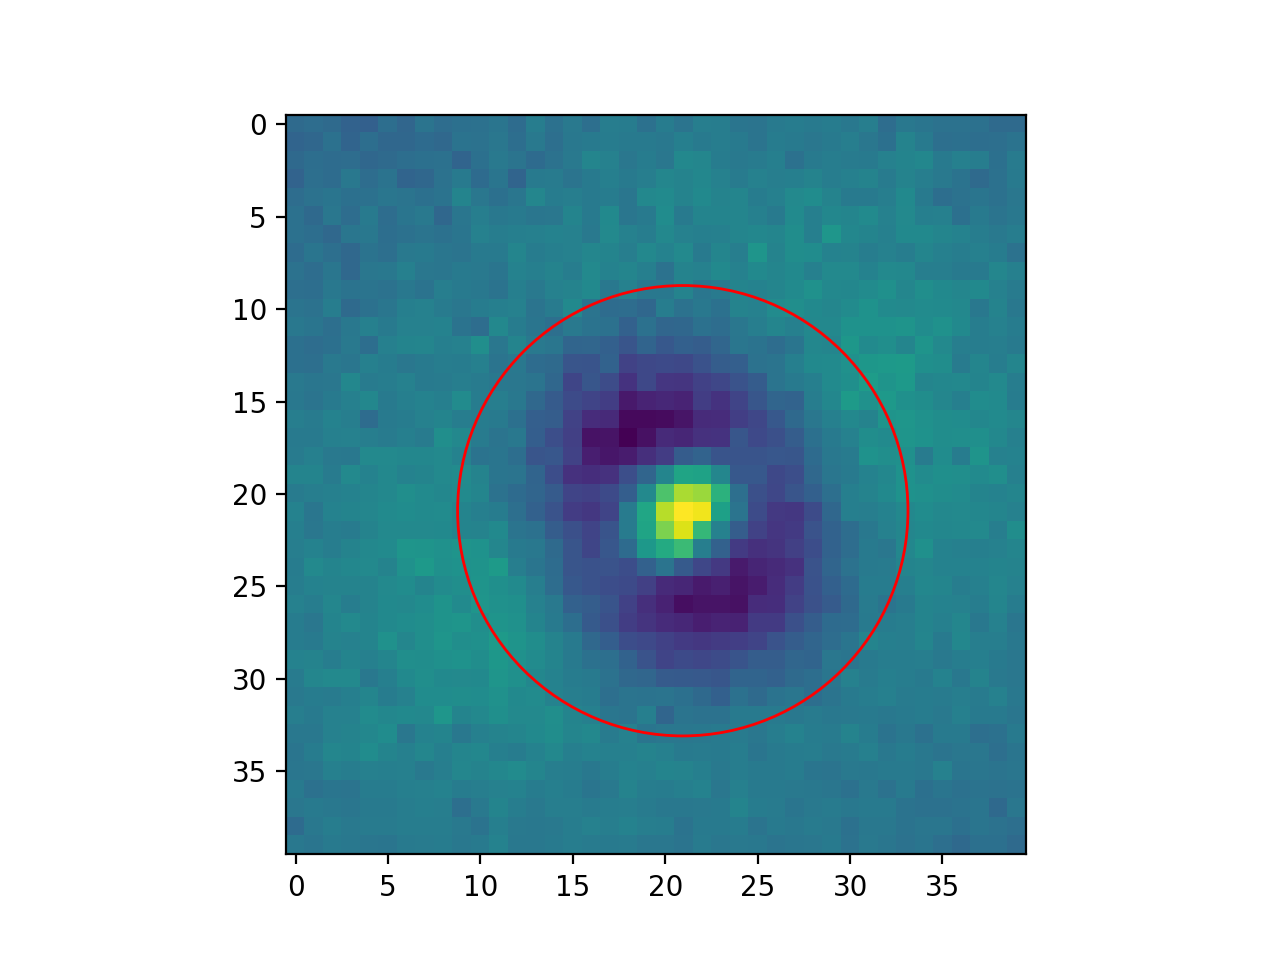

In [285]:
# Testing gaussian fitting

%matplotlib notebook
import astropy.io.fits as fits
import os
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Normalizing data
data = sdata / np.max(sdata)

# Getting Initial values
sigma = 2.0                   # in pixels

# Getting amp from data frame
amp = df.peak[df.id == sid]
amp_init = np.float(amp) / np.max(sdata)

# Changing origing of the reference system
x_init, y_init = x0 - x1, y0 - y1

# Getting grid
yi, xi = np.indices(data.shape)

#  Getting initial model
g_init = models.Gaussian2D(amp_init, x_init, y_init, sigma, sigma)

# Tieding up sigma 
#def tie_sigma(model):
#    return model.y_stddev

g_init.x_stddev.tied = tie_sigma

# Fitting 
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, xi, yi, data)

# Applying fitting to grid
model_data = g(xi, yi)

fig, ax = plt.subplots()
ax.imshow(data, label='Gaussian', origin='lower') 
ax.imshow(data-model_data, label='Gaussian') 
circle = Circle((g.x_mean.value, g.y_mean.value),
                1.0 * g.x_fwhm, facecolor ='None',
                edgecolor = 'red', linewidth = 1)

ax.add_patch(circle)
plt.show()


In [277]:
g.amplitude * np.max(sdata)

237.15735415868463

In [218]:
g.parameters

array([ 0.90500356, 20.64121638, 20.82336057,  2.18001662,  2.18001662,
        0.        ])

In [219]:
seeing = g.x_fwhm*header['scale']

seeing

0.8213674943976987

In [200]:
help(models.Gaussian2D)

Help on class Gaussian2D in module astropy.modeling.functional_models:

class Gaussian2D(astropy.modeling.core.Fittable2DModel)
 |  Gaussian2D(amplitude=1, x_mean=0, y_mean=0, x_stddev=None, y_stddev=None, theta=None, cov_matrix=None, **kwargs)
 |  
 |  Two dimensional Gaussian model.
 |  
 |  Parameters
 |  ----------
 |  amplitude : float
 |      Amplitude of the Gaussian.
 |  x_mean : float
 |      Mean of the Gaussian in x.
 |  y_mean : float
 |      Mean of the Gaussian in y.
 |  x_stddev : float or None
 |      Standard deviation of the Gaussian in x before rotating by theta. Must
 |      be None if a covariance matrix (``cov_matrix``) is provided. If no
 |      ``cov_matrix`` is given, ``None`` means the default value (1).
 |  y_stddev : float or None
 |      Standard deviation of the Gaussian in y before rotating by theta. Must
 |      be None if a covariance matrix (``cov_matrix``) is provided. If no
 |      ``cov_matrix`` is given, ``None`` means the default value (1).
 |  th